Imports!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline


Load the dataset into a dataframe, printing the first few lines

In [ ]:
df = pd.read_csv('pga_results_2001-may2024.tsv', sep='\t')
df.head()


,season,start,end,tournament,location,position,name,score,round1,round2,round3,round4,total,earnings,fedex_points
0,2001,2001-01-11,2001-01-14,Touchstone Energy Tucson Open,Omni Tucson National Golf Resort and Spa - Tuc...,1,Garrett Willis,-15,71.0,69.0,64.0,69.0,273.0,540000.0,NaN
1,2001,2001-01-11,2001-01-14,Touchstone Energy Tucson Open,Omni Tucson National Golf Resort and Spa - Tuc...,2,Kevin Sutherland,-14,67.0,72.0,67.0,68.0,274.0,324000.0,NaN
2,2001,2001-01-11,2001-01-14,Touchstone Energy Tucson Open,Omni Tucson National Golf Resort and Spa - Tuc...,T3,Bob Tway,-13,73.0,69.0,67.0,66.0,275.0,174000.0,NaN
3,2001,2001-01-11,2001-01-14,Touchstone Energy Tucson Open,Omni Tucson National Golf Resort and Spa - Tuc...,T3,Geoff Ogilvy,-13,67.0,72.0,68.0,68.0,275.0,174000.0,NaN
4,2001,2001-01-11,2001-01-14,Touchstone Energy Tucson Open,Omni Tucson National Golf Resort and Spa - Tuc...,T5,K.J. Choi,-12,70.0,70.0,70.0,66.0,276.0,105375.0,NaN


General dataset analysis- shape, types, column names, push to list

In [ ]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Data types:\n{df.dtypes}")
print(f"Column names:\n{df.columns}")

print("Columns:", df.columns.tolist())


Dataset contains 140542 rows and 15 columns.
Data types:
season            int64
start            object
end              object
tournament       object
location         object
position         object
name             object
score            object
round1          float64
round2          float64
round3          float64
round4          float64
total           float64
earnings        float64
fedex_points    float64
dtype: object
Column names:
Index(['season', 'start', 'end', 'tournament', 'location', 'position', 'name',
       'score', 'round1', 'round2', 'round3', 'round4', 'total', 'earnings',
       'fedex_points'],
      dtype='object')
Columns: ['season', 'start', 'end', 'tournament', 'location', 'position', 'name', 'score', 'round1', 'round2', 'round3', 'round4', 'total', 'earnings', 'fedex_points']


Convert 'score' to float by removing non-numeric characters

In [ ]:
df['score'] = pd.to_numeric(df['score'].str.replace('[^0-9.-]', '', regex=True), errors='coerce')

print(df['score'].dtype)
print(df['score'].head())


float64
0   -15.0
1   -14.0
2   -13.0
3   -13.0
4   -12.0
Name: score, dtype: float64


Convert 'position' to numeric value (removing the "T" and converting T1-T10 to integers)

In [ ]:
def convert_position(pos):
    if isinstance(pos, str) and pos.startswith('T'):
        return int(pos[1:])
    else:
        try:
            return int(pos)
        except:
            return np.nan

df['position'] = df['position'].apply(convert_position)

df[['position']].head()


,position
0,1.0
1,2.0
2,3.0
3,3.0
4,5.0


Drop rows in essential columns that are missing values, missing values in location, earnings, and fedex_points are non-essential, check for remaining missing values

In [ ]:
df.dropna(subset=['score','position','round1', 'round2', 'round3', 'round4'], inplace=True)

print("Missing values after dropping rows:")
print(df.isnull().sum())


Missing values after dropping rows:
season              0
start               0
end                 0
tournament          0
location         2217
position            0
name                0
score               0
round1              0
round2              0
round3              0
round4              0
total               0
earnings          513
fedex_points    23307
dtype: int64


Encode tournament and location using LabelEncoder. This is going to convert the string values in these columns to encoded integers for better interpretation from the model.

In [ ]:
le_tournament = LabelEncoder()
le_location = LabelEncoder()


df['tournament_encoded'] = le_tournament.fit_transform(df['tournament'])
df['location_encoded'] = le_location.fit_transform(df['location'])


df.drop(['tournament', 'location'], axis=1, inplace=True)
df[['tournament_encoded', 'location_encoded']].head()


,tournament_encoded,location_encoded
0,190,72
1,190,72
2,190,72
3,190,72
4,190,72


Now we're getting into the meat of the project. Here we create our target variable "is_top10". This is a binary value where 1 represents a T10 finish in a tournament, and 0 represents a non T10 finish. By doing this, the task of prediction is simplified to binary classification.

In [ ]:
df['is_top10'] = df['position'].apply(lambda x: 1 if x <= 10 else 0)

print(df['is_top10'].value_counts())


is_top10
0    59643
1    12241
Name: count, dtype: int64


Scale the essential numerical features so they contribute equally to the ML process using StandardScaler

In [ ]:
scaler = StandardScaler()

numerical_features = ['score', 'round1', 'round2', 'round3', 'round4']

df[numerical_features] = scaler.fit_transform(df[numerical_features])

df[numerical_features].head()


,score,round1,round2,round3,round4
0,-0.772606,0.447359,-0.227064,-2.044922,-0.568096
1,-0.706168,-1.011581,0.857376,-1.107151,-0.867357
2,-0.639729,1.176829,-0.227064,-1.107151,-1.465881
3,-0.639729,-1.011581,0.857376,-0.794560,-0.867357
4,-0.573291,0.082624,0.134416,-0.169380,-1.465881


Retain 'name' to associate the golfer with their prediction by name, but excludes the 'name' criteria in the ML process to avoid cardinality issues.  

In [ ]:
names = df['name']

df.drop(['name'], axis=1, inplace=True)

df.head()


,season,start,end,position,score,round1,round2,round3,round4,total,earnings,fedex_points,tournament_encoded,location_encoded,is_top10
0,2001,2001-01-11,2001-01-14,1.0,-0.772606,0.447359,-0.227064,-2.044922,-0.568096,273.0,540000.0,NaN,190,72,1
1,2001,2001-01-11,2001-01-14,2.0,-0.706168,-1.011581,0.857376,-1.107151,-0.867357,274.0,324000.0,NaN,190,72,1
2,2001,2001-01-11,2001-01-14,3.0,-0.639729,1.176829,-0.227064,-1.107151,-1.465881,275.0,174000.0,NaN,190,72,1
3,2001,2001-01-11,2001-01-14,3.0,-0.639729,-1.011581,0.857376,-0.794560,-0.867357,275.0,174000.0,NaN,190,72,1
4,2001,2001-01-11,2001-01-14,5.0,-0.573291,0.082624,0.134416,-0.169380,-1.465881,276.0,105375.0,NaN,190,72,1


Since this data spans back to 2001, I'm really only concerned about the last decade because non-modern top performers have mostly aged-out of PGA elidgability since 2001. This is going to keep our model more relevant, and a bit more managable.

In [ ]:
df_final = df[(df['season'] >= 2014) & (df['season'] <= 2024)].copy()

print(f"Filtered dataset contains {df_final.shape[0]} rows and {df_final.shape[1]} columns.")
df_final.head()


Filtered dataset contains 31143 rows and 15 columns.


,season,start,end,position,score,round1,round2,round3,round4,total,earnings,fedex_points,tournament_encoded,location_encoded,is_top10
80960,2014,2013-10-10,2013-10-13,1.0,-0.905482,0.082624,-0.227064,-2.670102,-1.465881,267.0,900000.0,500.0,82,25,1
80961,2014,2013-10-10,2013-10-13,2.0,-0.772606,-0.282111,-0.950024,-1.732331,-0.867357,269.0,540000.0,300.0,82,25,1
80962,2014,2013-10-10,2013-10-13,3.0,-0.706168,1.906298,-0.950024,-2.044922,-2.064405,270.0,240000.0,133.0,82,25,1
80963,2014,2013-10-10,2013-10-13,3.0,-0.706168,-0.646846,-0.950024,0.143210,-2.064405,270.0,240000.0,133.0,82,25,1
80964,2014,2013-10-10,2013-10-13,3.0,-0.706168,0.082624,-1.311503,-0.794560,-1.465881,270.0,240000.0,133.0,82,25,1


Now I want to put more weight on recent performance metrics from 2023-2024, since athletic success is streaky and top performers in golf tend to have parabolic successes for 1 year+ while in high rankings.

In [ ]:

df_final['weight'] = df_final['season'].apply(lambda x: 2 if x >= 2023 else 1)


associate names with golfers in t10 positions, define feature set and target variables.

In [ ]:
names_final = names.loc[df_final.index]

x = df_final.drop(['is_top10', 'start', 'end', 'weight'], axis=1)
y = df_final['is_top10']
weights = df_final['weight']


Split data temporally into training and testing sets to evaluate model performance after initial training. Everything before 2024 will be training data, the 2024 season will be test data.

In [ ]:
train_data = df_final[df_final['season'] < 2024]
test_data = df_final[df_final['season'] == 2024]

x_train = train_data.drop(['is_top10', 'start', 'end', 'weight'], axis=1)
y_train = train_data['is_top10']
w_train = train_data['weight']

x_test = test_data.drop(['is_top10', 'start', 'end', 'weight'], axis=1)
y_test = test_data['is_top10']
names_test = names_final.loc[test_data.index]

print(f"Training set: {x_train.shape[0]} samples")
print(f"Testing set: {x_test.shape[0]} samples")



Training set: 29600 samples
Testing set: 1543 samples


Ensure there are no non-numeric values in x_train and x_test

In [ ]:
print("\nData types in x_train:")
print(x_train.dtypes)

object_cols_train = x_train.select_dtypes(include=['object']).columns.tolist()
object_cols_test = x_test.select_dtypes(include=['object']).columns.tolist()

print("\nNon-numeric columns in x_train:", object_cols_train)
print("Non-numeric columns in x_test:", object_cols_test)



Data types in x_train:
season                  int64
position              float64
score                 float64
round1                float64
round2                float64
round3                float64
round4                float64
total                 float64
earnings              float64
fedex_points          float64
tournament_encoded      int64
location_encoded        int64
dtype: object

Non-numeric columns in x_train: []
Non-numeric columns in x_test: []


There are some non-numeric values in 'start', 'end', and 'fedex_points', and I don't really care about earnings for the prediction, here I'm removing those columns.

In [ ]:
columns_to_drop = ['start', 'end', 'fedex_points', 'earnings']

columns_present_train = [col for col in columns_to_drop if col in x_train.columns]
columns_present_test = [col for col in columns_to_drop if col in x_test.columns]

x_train = x_train.drop(columns=columns_present_train)
x_test = x_test.drop(columns=columns_present_test)

print("\nColumns in x_train after dropping 'start' and 'end':")
print(x_train.columns.tolist())

print("\nColumns in x_test after dropping 'start' and 'end':")
print(x_test.columns.tolist())



Columns in x_train after dropping 'start' and 'end':
['season', 'position', 'score', 'round1', 'round2', 'round3', 'round4', 'total', 'tournament_encoded', 'location_encoded']

Columns in x_test after dropping 'start' and 'end':
['season', 'position', 'score', 'round1', 'round2', 'round3', 'round4', 'total', 'tournament_encoded', 'location_encoded']


Let's do some final verification here, let's make sure the data looks exactly the way we want it so we can train better.

In [ ]:
print("\nFinal data types in x_train:")
print(x_train.dtypes)

print("\nFinal data types in x_test:")
print(x_test.dtypes)

print("\nFinal columns in x_train:")
print(x_train.columns.tolist())

print("\nFinal columns in x_test:")
print(x_test.columns.tolist())



Final data types in x_train:
season                  int64
position              float64
score                 float64
round1                float64
round2                float64
round3                float64
round4                float64
total                 float64
tournament_encoded      int64
location_encoded        int64
dtype: object

Final data types in x_test:
season                  int64
position              float64
score                 float64
round1                float64
round2                float64
round3                float64
round4                float64
total                 float64
tournament_encoded      int64
location_encoded        int64
dtype: object

Final columns in x_train:
['season', 'position', 'score', 'round1', 'round2', 'round3', 'round4', 'total', 'tournament_encoded', 'location_encoded']

Final columns in x_test:
['season', 'position', 'score', 'round1', 'round2', 'round3', 'round4', 'total', 'tournament_encoded', 'location_encoded']


TRAINING THE MODEL! with logistic regression, because its excellent for performing binary classification tasks. Here we are training the weights as well

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1277
           1       1.00      1.00      1.00       266

    accuracy                           1.00      1543
   macro avg       1.00      1.00      1.00      1543
weighted avg       1.00      1.00      1.00      1543



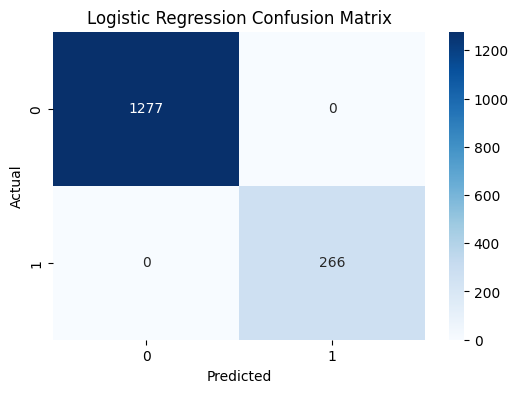

Predicted Top 10 Finishers:
                   Name  Actual  Predicted
0            Chris Kirk       1          1
1       Sahith Theegala       1          1
2         Jordan Spieth       1          1
3         Byeong Hun An       1          1
4            Sungjae Im       1          1
...                 ...     ...        ...
1485           Ryan Fox       1          1
1486  Chandler Phillips       1          1
1487     Keith Mitchell       1          1
1488          Sam Burns       1          1
1489        Joel Dahmen       1          1

[266 rows x 3 columns]


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train, sample_weight=w_train)

y_pred = log_reg.predict(x_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

df_predictions = pd.DataFrame({
    'Name': names_test.reset_index(drop=True),
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred
})

predicted_top10 = df_predictions[df_predictions['Predicted'] == 1]
print("Predicted Top 10 Finishers:")
print(predicted_top10)




Filter only tournments from the 2024 season (2025 is going to be a repeat sans olympics)

In [ ]:
tournaments_2024_encoded = x_test.loc[x_test['season'] == 2024, 'tournament_encoded'].unique()
available_tournaments_2024 = le_tournament.inverse_transform(tournaments_2024_encoded)

print("Available Tournaments in 2024 Test Set:")
for tournament in available_tournaments_2024:
    print(tournament)




Available Tournaments in 2024 Test Set:
The Sentry
Sony Open in Hawaii
The American Express
Farmers Insurance Open
WM Phoenix Open
The Genesis Invitational
Mexico Open at Vidanta
Cognizant Classic
Arnold Palmer Invitational pres. by Mastercard
Puerto Rico Open
THE PLAYERS Championship
Valspar Championship
Texas Children's Houston Open
Valero Texas Open
Masters Tournament
RBC Heritage
Corales Puntacana Championship
THE CJ CUP Byron Nelson
Wells Fargo Championship
Myrtle Beach Classic
PGA Championship
Charles Schwab Challenge
RBC Canadian Open


Select a tournament for prediction from the list above^^

Encode that tourney, filter test data and make predictions that show up below this cell.

In [ ]:
tournament_name = "The Sentry"  # copy and paste a tournament from the above list


try:
    tournament_encoded = le_tournament.transform([tournament_name])[0]
except ValueError:
    print(f"Tournament '{tournament_name}' not found in the encoder.")
    tournament_encoded = None

if tournament_encoded is not None:
    tournament_mask = x_test['tournament_encoded'] == tournament_encoded
    x_tournament = x_test[tournament_mask]
    names_tournament = names_test[tournament_mask]

    if not x_tournament.empty:
        y_prob = log_reg.predict_proba(x_tournament)[:,1]

        tournament_predictions = pd.DataFrame({
            'Name': names_tournament.reset_index(drop=True),
            'Probability': y_prob
        })

        predicted_top10 = tournament_predictions.sort_values(by='Probability', ascending=False).head(10)

        print("Predicted Top 10 Finishers for", tournament_name + ":")
        print(predicted_top10)
    else:
        print(f"No samples found for tournament '{tournament_name}' in the test set.")


Predicted Top 10 Finishers for The Sentry:
                Name  Probability
0         Chris Kirk     1.000000
5       Brian Harman     1.000000
8  Scottie Scheffler     1.000000
7    Collin Morikawa     1.000000
6        J.T. Poston     1.000000
1    Sahith Theegala     1.000000
4         Sungjae Im     1.000000
3      Byeong Hun An     1.000000
2      Jordan Spieth     1.000000
9          Jason Day     0.989604
